In [33]:
# 2023 NOV 02

In [34]:
import sklearn
import numpy as np
import pandas as pd

# prepare data

## example #1: titanic dataset

* functions for pre-processing

In [35]:
from sklearn.preprocessing import LabelEncoder

# drop
def drop_features(df, features):
    df.drop(features, axis=1, inplace=True)
    
# encode
def encode_features(df, features):
    encoder = LabelEncoder()
    for feature in features:
        encoder.fit(df[feature])
        df[feature] = encoder.transform(df[feature])
        
# null
def fill_nulls(df, instructions):
    for feature, method in instructions.items():
        if method == "N":
            df[feature].fillna("N", inplace=True)
        elif method == "mean":
            df[feature].fillna(df[feature].mean(), inplace=True)
        else:
            print("<!> unknown method")
            
# combined
def preprocess_features(df, features_to_drop, instructions_to_fill_null, features_to_encode):
    drop_features(df, features_to_drop)
    fill_nulls(df, instructions_to_fill_null)
    
    print("number of nulls in dataset:", df.isnull().sum().sum())
    
    encode_features(df, features_to_encode)

* load, extract, and pre-process data

In [36]:
# read & load
titanic_df = pd.read_csv("../data/titanic_train.csv")

feature_names = ["PaxID", "Survived", "Class", "Name", "Sex", "Age", "SibSpo", "ParChi", "Ticket", "Fare", "Cabin", "PortEmba"]
titanic_df.columns = feature_names

# extract features and targets
y = titanic_df["Survived"]
X = titanic_df.drop("Survived", axis=1, inplace=False)

# pre-process
features_to_drop = ["PaxID", "Name", "Ticket"]
instructions_to_fill_null = {"Age": "mean", "Cabin": "N", "PortEmba": "N"}
features_to_encode = ["Cabin", "Sex", "PortEmba"]

preprocess_features(X, features_to_drop, instructions_to_fill_null, features_to_encode)

display(X)

number of nulls in dataset: 0


,Class,Sex,Age,SibSpo,ParChi,Fare,Cabin,PortEmba
0,3,1,22.000000,1,0,7.2500,146,3
1,1,0,38.000000,1,0,71.2833,81,0
2,3,0,26.000000,0,0,7.9250,146,3
3,1,0,35.000000,1,0,53.1000,55,3
4,3,1,35.000000,0,0,8.0500,146,3
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,146,3
887,1,0,19.000000,0,0,30.0000,30,3
888,3,0,29.699118,1,2,23.4500,146,3
889,1,1,26.000000,0,0,30.0000,60,0


# prepare evaluation function

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [38]:
def evaluate(y_test, predictions):
    # confusion matrix
    print("confusion matrix:\n", confusion_matrix(y_test, predictions), "\n")
    
    # accuracy, precision & recall
    print(f"accuracy : {accuracy_score(y_test, predictions):.4f}")
    print(f"precision: {precision_score(y_test, predictions):.4f}")
    print(f"recall   : {recall_score(y_test, predictions):.4f}")

# train, predict, evaluation

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(712, 8) (179, 8) (712,) (179,)


In [40]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver="liblinear")

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [41]:
evaluate(y_test, predictions)

confusion matrix:
 [[108  10]
 [ 16  45]] 

accuracy : 0.8547
precision: 0.8182
recall   : 0.7377


# some functions to know

* predict_proba

In [42]:
proba = classifier.predict_proba(X_test)
predi = classifier.predict(X_test)

proba_predi = np.concatenate([proba, predi.reshape(-1, 1)], axis=1)
proba_predi_df = pd.DataFrame(proba_predi, columns=["Proba(Nega)", "Proba(Posi)", "Predi"])

display(proba_predi_df)

,Proba(Nega),Proba(Posi),Predi
0,0.453948,0.546052,1.0
1,0.865590,0.134410,0.0
2,0.865698,0.134302,0.0
3,0.838412,0.161588,0.0
4,0.808605,0.191395,0.0
...,...,...,...
174,0.502145,0.497855,0.0
175,0.912300,0.087700,0.0
176,0.852193,0.147807,0.0
177,0.581299,0.418701,0.0


* Binarizer

In [43]:
from sklearn.preprocessing import Binarizer

proba_posi = proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.5)  # predict as "positive" when positive propability is >= 0.5
binarizer.fit(proba_posi)

# binarizer: predict
predi_binarizer = binarizer.transform(proba_posi)

# classifier: predict
predi_classifier = classifier.predict(X_test)

In [44]:
print("binarizer predictions:")
evaluate(y_test, predi_binarizer)

print("\n", "classifier predictions:", sep="")
evaluate(y_test, predi_classifier)

# -> therefore, classifier indeed classifies as "positive" when positive propability is >= 0.5

binarizer predictions:
confusion matrix:
 [[108  10]
 [ 16  45]] 

accuracy : 0.8547
precision: 0.8182
recall   : 0.7377

classifier predictions:
confusion matrix:
 [[108  10]
 [ 16  45]] 

accuracy : 0.8547
precision: 0.8182
recall   : 0.7377


# confidence threshold sweep

In [45]:
thresholds = np.arange(0.4, 0.65, 0.05)

def evaluate_for_each_threshold(y_test, proba_posi, thresholds):
    for threshold in thresholds:
        binarizer = Binarizer(threshold=threshold)
        binarizer.fit(proba_posi)
        predi_binarizer = binarizer.transform(proba_posi)
        
        evaluate(y_test, predi_binarizer)
        
evaluate_for_each_threshold(y_test, proba_posi, thresholds)

confusion matrix:
 [[98 20]
 [11 50]] 

accuracy : 0.8268
precision: 0.7143
recall   : 0.8197
confusion matrix:
 [[106  12]
 [ 14  47]] 

accuracy : 0.8547
precision: 0.7966
recall   : 0.7705
confusion matrix:
 [[108  10]
 [ 16  45]] 

accuracy : 0.8547
precision: 0.8182
recall   : 0.7377
confusion matrix:
 [[111   7]
 [ 17  44]] 

accuracy : 0.8659
precision: 0.8627
recall   : 0.7213
confusion matrix:
 [[113   5]
 [ 18  43]] 

accuracy : 0.8715
precision: 0.8958
recall   : 0.7049


* precision_recall_curve()

In [54]:
from sklearn.metrics import precision_recall_curve

# get prediction probabilities for class 1 (ex. "survived")
proba_posi = classifier.predict_proba(X_test)[:, 1]

#
precisions, recalls, thresholds = precision_recall_curve(y_test, proba_posi)
# print(thresholds.shape, precisions.shape, recalls.shape)

# pick some indices 
num_thresholds = thresholds.shape[0];
indices = np.arange(0, num_thresholds, num_thresholds//10)

# print
print("thresholds:", np.round(thresholds[indices], 2))
print("precisions:", np.round(precisions[indices], 2))
print("recalls   :", np.round(recalls[indices], 2))

thresholds: [0.02 0.11 0.13 0.15 0.19 0.28 0.4  0.52 0.65 0.79 0.92]
precisions: [0.34 0.37 0.42 0.45 0.52 0.63 0.7  0.82 0.95 0.95 1.  ]
recalls   : [1.   1.   0.97 0.9  0.9  0.9  0.82 0.74 0.59 0.34 0.08]


* plot

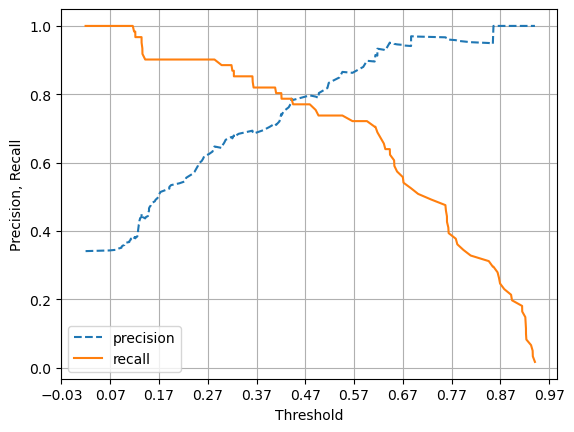

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_precision_recall_curve(y_test, proba_posi):
    precisions, recalls, thresholds = precision_recall_curve(y_test, proba_posi)
    
    plt.figure()
    num_thresholds = thresholds.shape[0];
    
    plt.plot(thresholds, precisions[0:num_thresholds], linestyle='--', label="precision")
    plt.plot(thresholds, recalls[0:num_thresholds], label="recall")
    
    # options
    x_start, x_end = plt.xlim()
    plt.xticks(np.round(np.arange(x_start, x_end, 0.1), 2))
    
    plt.xlabel("Threshold");
    plt.ylabel("Precision, Recall");
    plt.legend();
    plt.grid();
    plt.show();
    
plot_precision_recall_curve(y_test, proba_posi)    